# Artificial Neural Networks for Weather Forecasting




THEORY

figure no 1 :

The neural network depicted above contains an input layer on the far left representing two features, x1 and x2, that are feeding the neural network.  Those two features are fed into the neural network which are processed and transmitted through two layers of neurons which are referred to as hidden layers. This depiction shows two hidden layers with each layer containing three neurons (nodes).  The signal then exits the neural network and is aggregated at the output layer as a single numerical predicted value. 

Each arrow represents a mathematical transformation of a value beginning at the arrow's base which is then multiplied by a weight specific to that path.  Each node within a layer will be fed a value in this way. Then all the values converging at the node are summed.  It is this aggregate of multiplying by weights and summing the products that define the linear operations of a neural network.

FIGURE NO:2

After summation is carried out at each node a special, non-linear, function is applied to the sum which is depicted in the image above as **Fn(...)**.  This special function that introduces non-linear characteristics into a neural network is called an activation function.  It is this non-linear characteristic brought about by activation functions that give multilayer neural networks their power.  If it was not for the non-linearity added to the process then all layers would effectively just algebraically combine into one constant operation consisting of multiplying the inputs by some flat coefficient value (ie, a linear model). 

### TensorFlow's High Level Estimator API 


The TensorFlow team developed the Estimator API to make the library more accessible to the everyday developer.  This high level API provides a common interface to `train(...)` models, `evaluate(...)` models, and `predict(...)` outcomes of unknown cases similar to (and influenced by) the popular Sci-Kit Learn library which is accomplished by implementing a common interface.  Also, built into the high level API are a load of machine learning best practices, abstractions, and ability for scalability.

All of this machine learning goodness brings about a set of tools implemented in the base Estimator class as well as multiple pre-canned model types that lowers the barrier to entry for using TensorFlow so it can be applied to a host of everyday problems (or opportunities).  By abstracting away much of the mundane and manual aspects of things like writing training loops or dealing with sessions the developer is able to focus on more important things like rapidly trying multiple models and model architectures to find the one that best fits their need.  this project will be describing how to use one of the very powerful deep neural network estimators, the DNNRegressor.

### Building a DNNRegressor to Predict the Weather



In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split

Reading of Data

In [4]:
# read in the csv data into a pandas data frame and set the date as the index
df = pd.read_csv('final_data.csv').set_index('date')

# execute the describe() function and transpose the output so that it doesn't overflow the width of the screen
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantempm,3652.0,19.683311,5.094307,6.75,15.100,21.05,24.35,28.35
meantempm_1,3652.0,19.683009,5.094800,6.75,15.100,21.05,24.35,28.35
meantempm_2,3652.0,19.682640,5.095396,6.75,15.100,21.05,24.35,28.35
meantempm_3,3652.0,19.682256,5.096011,6.75,15.100,21.05,24.35,28.35
maxtempm,3652.0,26.448658,4.380177,10.00,23.175,27.60,30.00,35.20
mintempm,3652.0,12.917963,6.416987,-2.00,7.275,13.40,19.40,22.40
maxtempm_1,3652.0,26.448740,4.380059,10.00,23.175,27.60,30.00,35.20
mintempm_1,3652.0,12.917278,6.418093,-2.00,7.275,13.40,19.40,22.40
maxtempm_2,3652.0,26.448686,4.380134,10.00,23.175,27.60,30.00,35.20
mintempm_2,3652.0,12.916594,6.419199,-2.00,7.275,13.40,19.40,22.40


In [5]:
# execute the info() function
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3652 entries, 1/1/2008 to 12/31/2017
Data columns (total 18 columns):
meantempm      3652 non-null float64
meantempm_1    3652 non-null float64
meantempm_2    3652 non-null float64
meantempm_3    3652 non-null float64
maxtempm       3652 non-null float64
mintempm       3652 non-null float64
maxtempm_1     3652 non-null float64
mintempm_1     3652 non-null float64
maxtempm_2     3652 non-null float64
mintempm_2     3652 non-null float64
maxtempm_3     3652 non-null float64
mintempm_3     3652 non-null float64
precipm_1      3652 non-null float64
precipm_2      3652 non-null float64
precipm_3      3652 non-null float64
humidity_1     3652 non-null float64
humidity_2     3652 non-null float64
humidity_3     3652 non-null float64
dtypes: float64(18)
memory usage: 542.1+ KB


remove the mintempm and maxtempm columns as they have no meaning in helping us predict the average mean temperatures, we are predicting the future
</br>also separate out the features (X) from the targets (y).

In [6]:
# First drop the maxtempm and mintempm from the dataframe
df = df.drop(['mintempm', 'maxtempm'], axis=1)

# X will be a pandas dataframe of all columns except meantempm
X = df[[col for col in df.columns if col != 'meantempm']]

# y will be a pandas series of the meantempm
y = df['meantempm']

 dividing  dataset into training and testing sets.   `train_test_split(...)`.

In [7]:
# split data into training set and a temporary set using sklearn.model_selection.traing_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)

In [8]:
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

X_train.shape, X_test.shape, X_val.shape
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))

Training instances   2921, Training features   15
Validation instances 366, Validation features 15
Testing instances    365, Testing features    15


The first step to take in building a neural network model is to instantiate the `tf.estimator.DNNRegressor(...)` class.  The class constructor has multiple parameters but I will be focusing on the following:

* feature_columns: list-like structure containing a definition of the name and data types for the features being fed into the model
* hidden_units: list-like structure containing a definition of the number width and depth of the neural network
* optimizer: an instance of tf.Optimizer subclass which optimizes the model's weights during training; has a default is the AdaGrad optimizer.
* activation_fn: an activation function used to introduce non-linearity into the network at each layer; the default is ReLU
* model_dir: a directory to be created that will contain metadata and other checkpoint saves for the model


In [9]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

feature columns defined,</br>
now instantiate the DNNRegressor class and store it in the regressor variable. 
</br> model data stored in a directory called *tf_wx_model*.

In [29]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002665419DB00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


define a reusable function that is generically referred to as an input function which is call `wx_input_fn(...)`.  This function will be used to feed data into  neural network during the training and testing phases. T`tf.estimator.inputs.pandas_input_fn(...)`

In [30]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=1850):
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)



The parameters to the function are defined as follows:
* X: the input features to be fed into one of the three DNNRegressor interface methods `train`, `evaluate`, and `predict`
* y: the target values of X, which are optional and will not be supplied to the `predict` call
* num_epochs: optional parameter. An epoch occurs when the algorithm executes over the entire dataset one time.  
* shuffle: optional, specifies whether to randomly select a batch (subset) of the dataset each time the algorithm executes
* batch_size: the number of samples to include each time the algorithm executes

In [ ]:
evaluations = []
STEPS = 500
for i in range(100):
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluation = regressor.evaluate(input_fn=wx_input_fn(X_val, y_val,
                                                         num_epochs=1,
                                                         shuffle=False),
                                    steps=1)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

The above loop iterates 100 times. In the body of the loop,  `train(...)` method of the regressor object passing it my reusable `wx_input_fn(...)` which is in turn passed  training feature set and targets. The final parameter to the `train(...)` method is `steps` which I set to 500 which means the training set will be batched 500 times per loop.  

</br>
 `evaluate(...)` method for each iteration of the loop and captured its output in a list.  When `train(...)` method is fired.  It selects a random batch of training records and pushes them through the network until a prediction is made, and for each record the loss function is calculated.  Then based off the loss calculated the weights are adjusted according to the optimizer's logic which does a pretty good job at making adjustments towards the direction that reduces the overall loss for the next iteration.  These loss values, in general as long as the learning rate is small enough, decline over time with each iteration or step. 

However, after a certain amount of these learning iterations the weights start to be influenced not just by the overall trends in the data but, also by the uninformative noise inherit in virtually all real data.  At this point the network is over influenced by the idiosyncrasies of the training data and becomes unable to gereralize predictions about the overall population of data (ie, data it has not yet seen).  

In [32]:
evaluations[0]

{'average_loss': 1.1656892,
 'label/mean': 19.77787,
 'loss': 426.64224,
 'prediction/mean': 19.831203,
 'global_step': 185500}

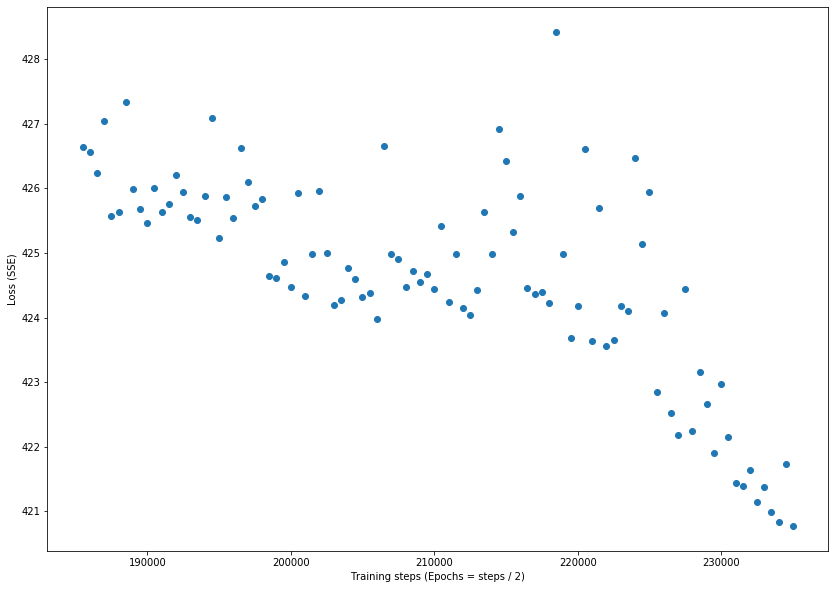

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.show()

 From the chart above it looks like after all those iterations model is not overfitted because the evaluation losses never exhibit a significant change in direction toward an increasing value.  

In [34]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

print("The Explained Variance: %.2f" % explained_variance_score(
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(
                                            y_test, predictions))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-235000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The Explained Variance: 0.94
The Mean Absolute Error: 0.86 degrees Celcius
The Median Absolute Error: 0.65 degrees Celcius


<h1>Conclusion</h1>
</br>
R2=0.94, i.e. the regression model explained about 94% of total variations, suggests that the regression model has high forecast accuracy and cannot predict only 6% of mean temperature variables.
which indicates the good performance of the model in predicting the mean temperature
